In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from functions import *

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import adjusted_rand_score

from datetime import datetime, timezone

# 1. Loading datas

In [2]:
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_row', 50)

In [3]:
full_data = pd.read_csv('cleaned_data.csv', sep=',')
full_data.head()

,Unnamed: 0,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,customer_geolocation_lat,customer_geolocation_lng,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,product_id,seller_id,shipping_limit_date,nb_items,total_price,total_freight_value,mean_price,mean_freight_value,prefered_product_category_name,mean_product_name_lenght,mean_product_description_lenght,mean_product_photos_qty,mean_product_weight_g,mean_product_length_cm,mean_product_height_cm,mean_product_width_cm,review_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp,nb_payments,prefered_payment_type,mean_payment_installments,total_payment_value,mean_payment_value,max_payment_value,min_payment_value
0,0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,-20.498489,-47.396929,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,2017-05-16 15:22:12,2017-05-23 10:47:57,2017-05-25 10:35:35,2017-06-05,['a9516a079e37a9c9c36b9b78b10169e8'],['7c67e1448b00f6e969d365cea6b010ab'],2017-05-22 15:22:12,1.0,124.99,21.88,124.99,21.88,office_furniture,41.0,1141.0,1.0,8683.0,54.0,64.0,31.0,88b8b52d46df026a9d1ad2136a59b30b,4.0,Not applicable,Not applicable,2017-05-26 00:00:00,2017-05-30 22:34:40,1.0,credit_card,2.0,146.87,146.87,146.87,146.87
1,1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP,-23.727992,-46.542848,29150127e6685892b6eab3eec79f59c7,delivered,2018-01-12 20:48:24,2018-01-12 20:58:32,2018-01-15 17:14:59,2018-01-29 12:41:19,2018-02-06,['4aa6014eceb682077f9dc4bffebc05b0'],['b8bc237ba3788b23da09c0f1f3a3288c'],2018-01-18 20:58:32,1.0,289.00,46.48,289.00,46.48,housewares,43.0,1002.0,3.0,10150.0,89.0,15.0,40.0,02fc48a9efa3e3d0f1a8ea26507eeec3,5.0,Not applicable,Not applicable,2018-01-30 00:00:00,2018-02-10 22:43:29,1.0,credit_card,8.0,335.48,335.48,335.48,335.48
2,2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP,-23.531642,-46.656289,b2059ed67ce144a36e2aa97d2c9e9ad2,delivered,2018-05-19 16:07:45,2018-05-20 16:19:10,2018-06-11 14:31:00,2018-06-14 17:58:51,2018-06-13,['bd07b66896d6f1494f5b86251848ced7'],['7c67e1448b00f6e969d365cea6b010ab'],2018-06-05 16:19:10,1.0,139.94,17.79,139.94,17.79,office_furniture,55.0,955.0,1.0,8267.0,52.0,52.0,17.0,5ad6695d76ee186dc473c42706984d87,5.0,Not applicable,Not applicable,2018-06-15 00:00:00,2018-06-15 12:10:59,1.0,credit_card,7.0,157.73,157.73,157.73,157.73
3,3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP,-23.499702,-46.185233,951670f92359f4fe4a63112aa7306eba,delivered,2018-03-13 16:06:38,2018-03-13 17:29:19,2018-03-27 23:22:42,2018-03-28 16:04:25,2018-04-10,['a5647c44af977b148e0a3a4751a09e2e'],['7c67e1448b00f6e969d365cea6b010ab'],2018-03-27 16:31:16,1.0,149.94,23.36,149.94,23.36,office_furniture,48.0,1066.0,1.0,12160.0,56.0,51.0,28.0,059a801bb31f6aab2266e672cab87bc5,5.0,Not applicable,Not applicable,2018-03-29 00:00:00,2018-04-02 18:36:47,1.0,credit_card,1.0,173.30,173.30,173.30,173.30
4,4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP,-22.975100,-47.142925,6b7d50bd145f6fc7f33cebabd7e49d0f,delivered,2018-07-29 09:51:30,2018-07-29 10:10:09,2018-07-30 15:16:00,2018-08-09 20:55:48,2018-08-15,['9391a573abe00141c56e38d84d7d5b3b'],['4a3ca9315b744ce9f8e9374361493884'],2018-07-31 10:10:09,1.0,230.00,22.25,230.00,22.25,home_confort,61.0,407.0,1.0,5200.0,45.0,15.0,35.0,8490879d58d6c5d7773f2739a03f089a,5.0,a melhor nota,O baratheon è esxelente Amo adoro o baratheon,2018-08-10 00:00:00,2018-08-17 01:59:52,1.0,credit_card,8.0,252.25,252.25,252.25,252.25


In [4]:
# Reformating datas in full_data

full_data['order_purchase_timestamp'] = pd.to_datetime(full_data['order_purchase_timestamp'])

# Transforming review_score in NaN and float in the inital df
def to_float(elt):
    if elt == 'Not applicable':
        return np.nan
    else:
        return float(elt)

full_data['review_score'] = full_data['review_score'].apply(to_float)

# 2. Analysis of time of maintenance

## I - First iteration

In [5]:
# Look to the most recent and oldest date in the dataset
print(max(full_data['order_purchase_timestamp']))
print(min(full_data['order_purchase_timestamp']))

2018-10-17 17:30:18
2016-09-04 21:15:19


In [6]:
# Let's find a date in the middle for our first reference date

time_diff = (max(full_data['order_purchase_timestamp']) - min(full_data['order_purchase_timestamp']))
reference_date = min(full_data['order_purchase_timestamp']) + (time_diff / 2)

Reference date : 2017-9-26
Date from which reference model isn't working well enough : 2017-11-7
In days from reference date : 42
In weeks from reference date : 6


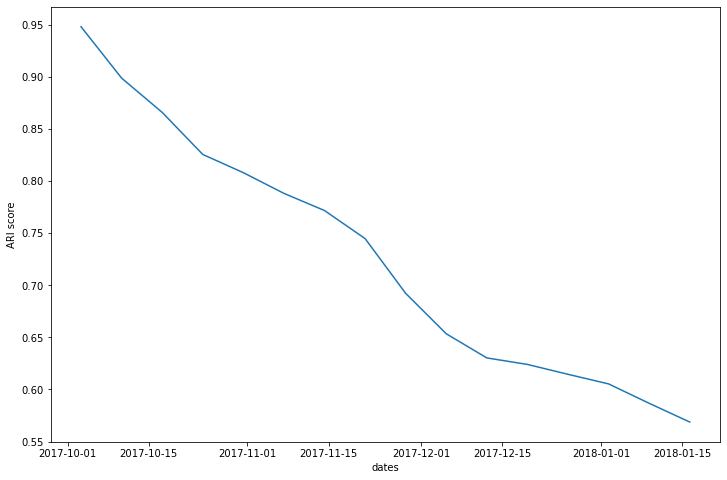

In [7]:
# Find the date from which the initial model isn't working well enough
compute_maintenance_time(reference_date, full_data, delta_days=7, nb_delta_days=16, ARI_treshold=0.8)

## II - Second iteration

In [8]:
# We will try to get closer to the last available date to get a maintenance time based on the most recent data

# We take 80 days delta vs. 42 to keep a security margin
reference_date = max(full_data['order_purchase_timestamp']) - pd._libs.tslibs.timedeltas.Timedelta(80, unit='D')

Reference date : 2018-7-29
Date from which reference model isn't working well enough : 2018-8-26
In days from reference date : 28
In weeks from reference date : 4


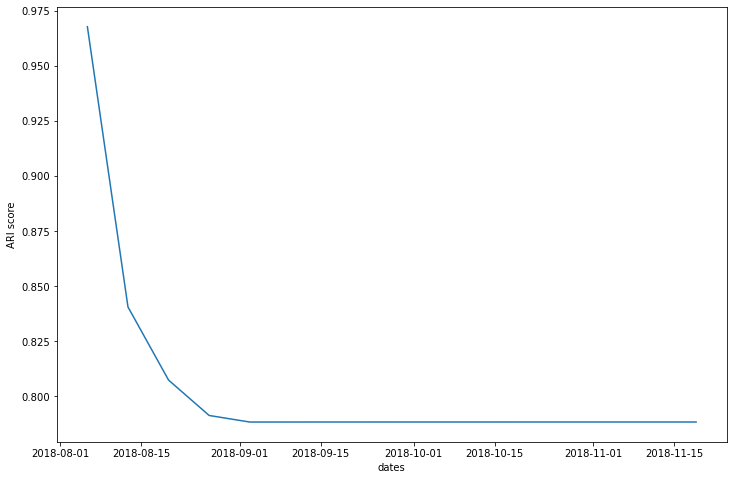

In [9]:
# Find the date from which the initial model isn't working well enough
compute_maintenance_time(reference_date, full_data, delta_days=7, nb_delta_days=16, ARI_treshold=0.8)

We can conclude we need a monthly maintenance to keep a satisfying model with new orders